<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/25_4_Lenta_ru_stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе необходимо с помощью AutoKeras или KerasTuner найти оптимальную модель для решения одной из следующей задач:

1. На 3 балла. Обучите модель с точностью не менее 90% предсказывать сарказм в новостных заголовках. Составьте 5 произвольных заголовков, которых нет в датасете и проверьте на них обученную модель, сделайте выводы. Ссылка на [датасет](https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip).
2. На 4 балла. Используйте [русский корпус новостей от Lenta.ru](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta/data) подберите и обучите модель классифицировать новости по заголовкам на классы (поле topic в датасете). Используйте 9 самых часто встречаемых топиков и 10-й для остальных, не вошедших в 9 классов. Оцените модель с помощью отчета о классификации, сделайте выводы.  
3. На 5 баллов. Найдите публичный датасет по обращениям граждан в администрацию, техническую поддержку или за консультацией. Обучите модель классифицировать обращения по тематикам. Сформируйте отчет о классификации и матрицу ошибок.

In [ ]:
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1

INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.1/527.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.0 MB/s eta 

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

In [ ]:
!wget https://storage.yandexcloud.net/for-telegram-bot2/Russian_news_corps_lenta_ru.zip

--2024-11-07 12:27:50--  https://storage.yandexcloud.net/for-telegram-bot2/Russian_news_corps_lenta_ru.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611887272 (584M) [application/x-zip-compressed]
Saving to: ‘Russian_news_corps_lenta_ru.zip’

Russian_news_corps_ 100%[===================>] 583.54M  8.96MB/s    in 69s     

2024-11-07 12:28:59 (8.51 MB/s) - ‘Russian_news_corps_lenta_ru.zip’ saved [611887272/611887272]



In [ ]:
!unzip -qo "Russian_news_corps_lenta_ru.zip" -d ./dataset

In [ ]:
data_path = "/content/dataset/lenta-ru-news.csv"
df = pd.read_csv(data_path)

<ipython-input-5-33e41decfc57>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [ ]:
df = df[['topic', 'title']]

In [ ]:
df['title'] = df['title'].apply(lambda x: str(x))

In [ ]:
df.head(3)

,topic,title
0,Библиотека,1914. Русские войска вступили в пределы Венгрии
1,Библиотека,1914. Празднование столетия М.Ю. Лермонтова от...
2,Библиотека,1914. Das ist Nesteroff!


In [ ]:
df.drop_duplicates(subset='title', inplace=True)

In [ ]:
df = df.dropna(subset='title')

In [ ]:
topics = df['topic'].value_counts().index[:9]
df.loc[~df['topic'].isin(topics), 'topic'] = 'Other'

In [ ]:
topic_num = {topic: idx for idx, topic in enumerate(df['topic'].unique())}
df['topic_num'] = df['topic'].map(topic_num)

In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df['title']), np.array(df['topic_num']),test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [ ]:
clf = ak.TextClassifier(overwrite=True, max_trials=1, objective='val_accuracy')
result_training = clf.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Trial 1 Complete [00h 08m 45s]
val_accuracy: 0.5843350291252136

Best val_accuracy So Far: 0.5843350291252136
Total elapsed time: 00h 08m 45s
Epoch 1/2
19946/19946 [==============================] - 187s 9ms/step - loss: 1.3457 - accuracy: 0.5482 - val_loss: 1.2196 - val_accuracy: 0.5795
Epoch 2/2
19946/19946 [==============================] - 176s 9ms/step - loss: 1.2464 - accuracy: 0.5778 - val_loss: 1.2041 - val_accuracy: 0.5852


In [ ]:
clf.export_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLas  (None, 1)                 0         
 tDim)                                                           
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           320064    
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          82176 

In [ ]:
predicted_y = clf.predict(X_test)
print(clf.evaluate(X_test, y_test))

2494/2494 [==============================] - 13s 5ms/step - loss: 1.1909 - accuracy: 0.5899
[1.1909148693084717, 0.589917778968811]


In [ ]:
def plot_graphs(history, key):
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')
    plt.figure(figsize=(6,3))
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[6],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[2],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    plt.xlabel("Эпоха", fontsize=6)
    plt.ylabel(key, fontsize=6)
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=8)
    plt.legend(fontsize=6)
    plt.grid(True)
    plt.show()

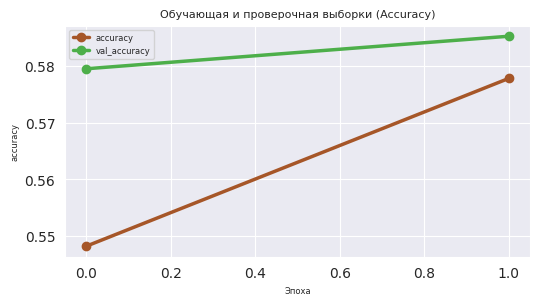

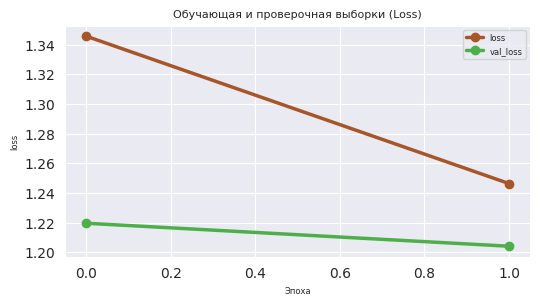

In [ ]:
plot_graphs(result_training, "accuracy")
plot_graphs(result_training, "loss")

In [ ]:
pred_y_int = np.array(predicted_y, dtype=int)
nl = '\n'
print(f"ОТЧЕТ О КЛАССИФИКАЦИИ: {nl} {classification_report(y_test, pred_y_int)}")

ОТЧЕТ О КЛАССИФИКАЦИИ: 
               precision    recall  f1-score   support

           0       0.51      0.41      0.45     12614
           1       0.52      0.69      0.59     16136
           2       0.60      0.70      0.64     13537
           3       0.69      0.60      0.64      7823
           4       0.63      0.39      0.48      4485
           5       0.80      0.81      0.80      6464
           6       0.59      0.54      0.56      5296
           7       0.44      0.15      0.23      2650
           8       0.54      0.57      0.56      5407
           9       0.66      0.63      0.64      5372

    accuracy                           0.59     79784
   macro avg       0.60      0.55      0.56     79784
weighted avg       0.59      0.59      0.58     79784



In [ ]:
import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

<ipython-input-21-3c44833159d2>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
vocab_size = 10000

# Выравниваем входные последовательности до заданной длины
sentence_len = 25

# Функция предобработки данных
def data_preparation(data):
    corpus=[]

    for text in data:
        # убираем из текстов все, что не является буквами
        text=re.sub("[^a-zA-Z]", " ", text)
        # Убираем все заглавные буквы
        text=text.lower()
        # Избавляемся от лишних пробелов
        text=text.split()
        text=" ".join(text)
        corpus.append(text)

    # Векторизуем текст
    oneHot_doc=[one_hot(input_text=words, n=vocab_size)
               for words in corpus
               ]
    # обрезаем или забиваем нулями до заданной длины входные последовательности
    embedded_doc=pad_sequences(sequences=oneHot_doc,
                              maxlen=sentence_len,
                              padding="post")
    return embedded_doc

In [ ]:
train_data = data_preparation(X_train)
test_data = data_preparation(X_test)

In [ ]:
X_train[0]
train_data[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)

In [ ]:
# Определение функции для построения модели
def build_model(hp):
    model = keras.Sequential()
    # Добавление слоев эмбеддинга
    model.add(layers.Embedding(input_dim=vocab_size,
      output_dim=hp.Int('embedding_dim', min_value=8, max_value=32, step=8) # задаем диапазон изменения параметра embedding_dim
    ))
    model.add(layers.GlobalAveragePooling1D())

    # Задаем количество слоев, их размерности и функции активации
    for i in range(hp.Int('num_layers', 1, 4)): # число слоев
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 256, 32), # размерность
                               activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid']))) # подбор функции активации
    model.add(layers.Dense(10, activation='sigmoid')) # Выходной слой

    # Определение оптимизатора и скомпилирование модели
    # learning_rate - выбирается из списка [1e-3, 1e-4, 1e-5]
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-5])),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
print(train_data.shape)
print(y_train.shape)

(638265, 25)
(638265,)


In [ ]:
tuner_search = RandomSearch(build_model, objective='val_accuracy', max_trials=3, directory='output')

# Запуск настройки гиперпараметров
tuner_search.search(train_data, y_train, epochs=4, validation_split=0.2)

# Получение наилучшей модели
best_model = tuner_search.get_best_models(num_models=1)[0]

# Оценка наилучшей модели на тестовых данных
test_loss, test_accuracy = best_model.evaluate(test_data, y_test)
print('Test accuracy:', test_accuracy)

Reloading Tuner from output/untitled_project/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |8                 |embedding_dim
2                 |1                 |num_layers
128               |160               |units_0
sigmoid           |tanh              |activation_0
1e-05             |1e-05             |learning_rate
96                |128               |units_1
relu              |tanh              |activation_1
256               |160               |units_2
tanh              |relu              |activation_2
64                |128               |units_3
relu              |tanh              |activation_3

Epoch 1/4


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_file01baqqo2.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible

